# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [2]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    if (large_ip_layer != None):
         concat = layers.concatenate([upsampled, large_ip_layer])
    else:
         concat = upsampled
    
    # TODO Add some number of separable convolution layers
    output_layer_inner = separable_conv2d_batchnorm(concat, filters)
    output_layer = separable_conv2d_batchnorm(output_layer_inner, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    print("Inputs  shape:",inputs.shape, "  \tImage Size in Pixels")
    
    layer01 = encoder_block(inputs , filters=32 , strides=2)
    print("layer01 shape:",layer01.shape, "  \tEncoder Block 1")
    
    layer02 = encoder_block(layer01, filters=64 , strides=2)
    print("layer02 shape:",layer02.shape, "  \tEncoder Block 2")
    
    layer03 = encoder_block(layer02, filters=128, strides=2)
    print("layer03 shape:",layer03.shape, "\tEncoder Block 3")

    # Add 1x1 Convolution layer using conv2d_batchnorm().
    layer04 = conv2d_batchnorm(layer03, filters=256, kernel_size=1, strides=1)
    print("layer04 shape:",layer04.shape, "\t1x1 Conv Layer")
    
    # Add the same number of Decoder Blocks as the number of Encoder Blocks
    layer05 = decoder_block(layer04, layer02, filters=128 )
    print("layer05 shape:",layer05.shape, "\tDecoder Block 1")
    
    layer06 = decoder_block(layer05, layer01, filters=64  )
    print("layer06 shape:",layer06.shape, "  \tDecoder Block 2")
    
    layer07 = decoder_block(layer06, inputs , filters=32  )
    print("layer07 shape:",layer07.shape, "\tDecoder Block 3")
    
    # The function returns the output layer of your model. "layer07" is the final layer obtained from the last decoder_block()
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(layer07)
    print("Outputs shape:",outputs.shape, "\tOutput Size in Pixel")
    
    return outputs

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Inputs  shape: (?, 160, 160, 3)   	Image Size in Pixels
layer01 shape: (?, 80, 80, 32)   	Encoder Block 1
layer02 shape: (?, 40, 40, 64)   	Encoder Block 2
layer03 shape: (?, 20, 20, 128) 	Encoder Block 3
layer04 shape: (?, 20, 20, 256) 	1x1 Conv Layer
layer05 shape: (?, 40, 40, 128) 	Decoder Block 1
layer06 shape: (?, 80, 80, 64)   	Decoder Block 2
layer07 shape: (?, 160, 160, 32) 	Decoder Block 3
Outputs shape: (?, 160, 160, 3) 	Output Size in Pixel


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.001
batch_size = 100
num_epochs = 200
steps_per_epoch = 41
validation_steps = 12
workers = 4

Epoch 1/200
40/41 [============================>.] - ETA: 1s - loss: 1.0032

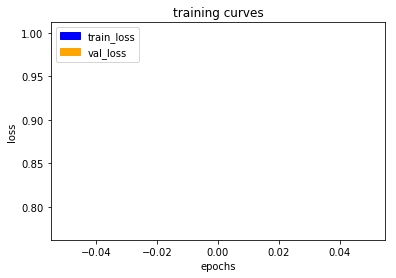

41/41 [==============================] - 81s - loss: 0.9969 - val_loss: 0.7733
Epoch 2/200
40/41 [============================>.] - ETA: 1s - loss: 0.5695

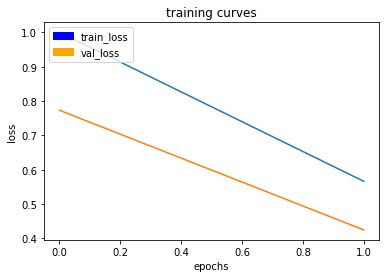

41/41 [==============================] - 77s - loss: 0.5663 - val_loss: 0.4248
Epoch 3/200
40/41 [============================>.] - ETA: 1s - loss: 0.3242

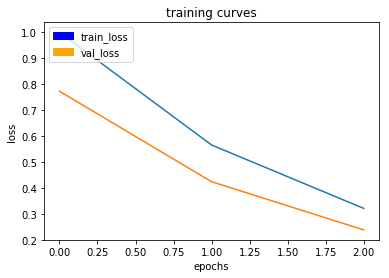

41/41 [==============================] - 74s - loss: 0.3223 - val_loss: 0.2391
Epoch 4/200
40/41 [============================>.] - ETA: 1s - loss: 0.1926

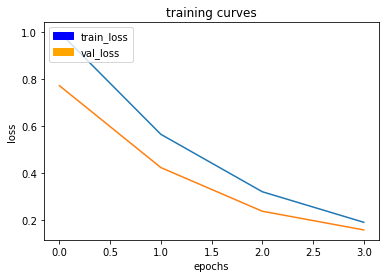

41/41 [==============================] - 77s - loss: 0.1920 - val_loss: 0.1596
Epoch 5/200
40/41 [============================>.] - ETA: 1s - loss: 0.1271

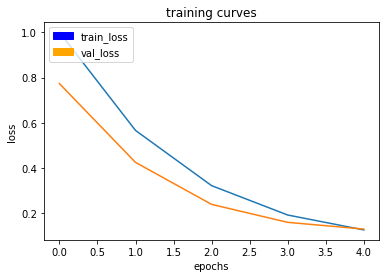

41/41 [==============================] - 76s - loss: 0.1264 - val_loss: 0.1299
Epoch 6/200
40/41 [============================>.] - ETA: 1s - loss: 0.0941

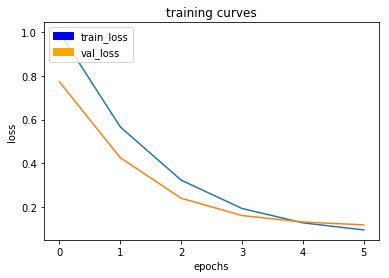

41/41 [==============================] - 76s - loss: 0.0939 - val_loss: 0.1169
Epoch 7/200
40/41 [============================>.] - ETA: 1s - loss: 0.0749

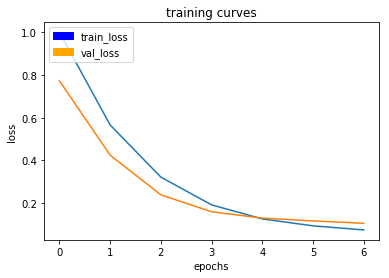

41/41 [==============================] - 76s - loss: 0.0747 - val_loss: 0.1056
Epoch 8/200
40/41 [============================>.] - ETA: 1s - loss: 0.0643

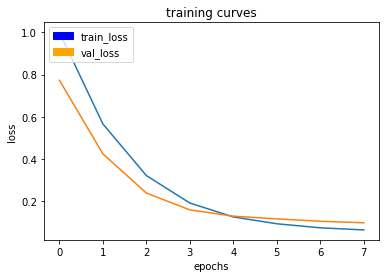

41/41 [==============================] - 76s - loss: 0.0645 - val_loss: 0.0984
Epoch 9/200
40/41 [============================>.] - ETA: 1s - loss: 0.0550

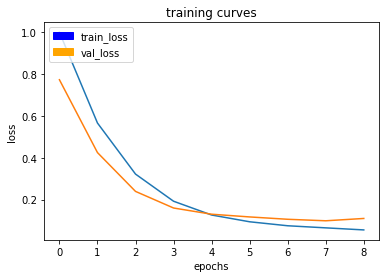

41/41 [==============================] - 75s - loss: 0.0547 - val_loss: 0.1096
Epoch 10/200
40/41 [============================>.] - ETA: 1s - loss: 0.0508

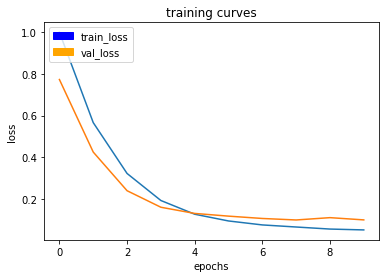

41/41 [==============================] - 76s - loss: 0.0506 - val_loss: 0.0988
Epoch 11/200
40/41 [============================>.] - ETA: 1s - loss: 0.0465

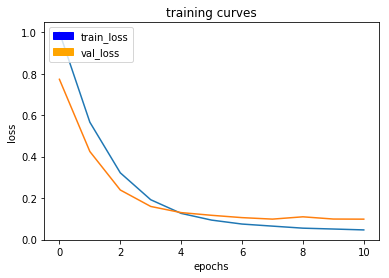

41/41 [==============================] - 76s - loss: 0.0463 - val_loss: 0.0983
Epoch 12/200
40/41 [============================>.] - ETA: 1s - loss: 0.0438

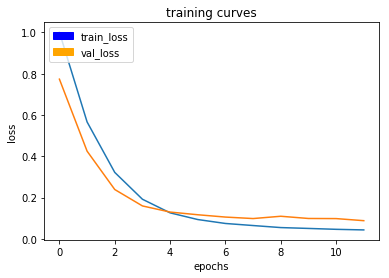

41/41 [==============================] - 76s - loss: 0.0437 - val_loss: 0.0881
Epoch 13/200
40/41 [============================>.] - ETA: 1s - loss: 0.0393

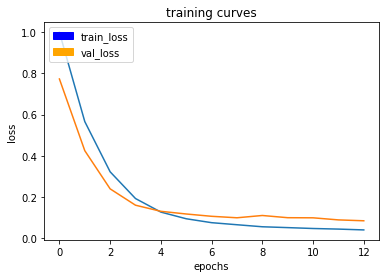

41/41 [==============================] - 76s - loss: 0.0394 - val_loss: 0.0838
Epoch 14/200
40/41 [============================>.] - ETA: 1s - loss: 0.0393

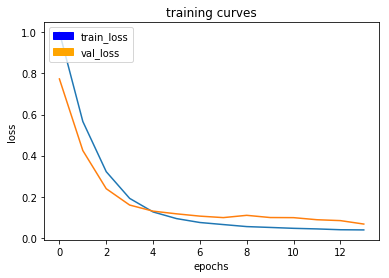

41/41 [==============================] - 76s - loss: 0.0392 - val_loss: 0.0671
Epoch 15/200
40/41 [============================>.] - ETA: 1s - loss: 0.0377

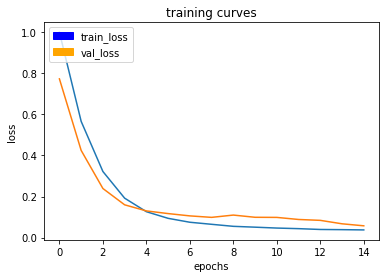

41/41 [==============================] - 76s - loss: 0.0375 - val_loss: 0.0573
Epoch 16/200
40/41 [============================>.] - ETA: 1s - loss: 0.0334

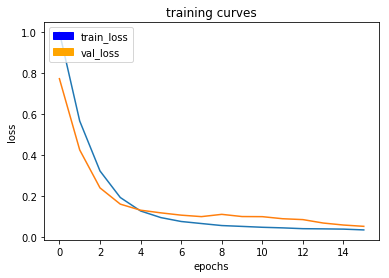

41/41 [==============================] - 76s - loss: 0.0334 - val_loss: 0.0509
Epoch 17/200
40/41 [============================>.] - ETA: 1s - loss: 0.0328

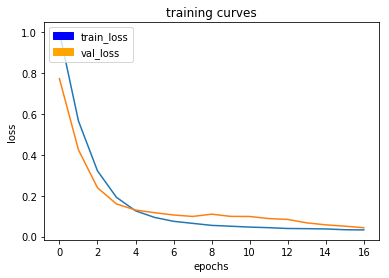

41/41 [==============================] - 76s - loss: 0.0327 - val_loss: 0.0432
Epoch 18/200
40/41 [============================>.] - ETA: 1s - loss: 0.0330

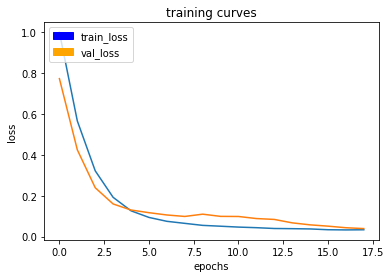

41/41 [==============================] - 75s - loss: 0.0332 - val_loss: 0.0390
Epoch 19/200
40/41 [============================>.] - ETA: 1s - loss: 0.0288

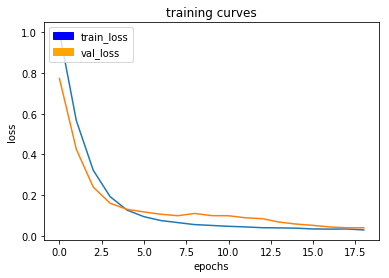

41/41 [==============================] - 76s - loss: 0.0287 - val_loss: 0.0392
Epoch 20/200
40/41 [============================>.] - ETA: 1s - loss: 0.0328

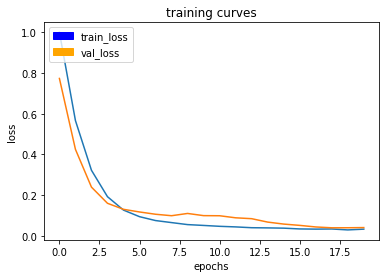

41/41 [==============================] - 76s - loss: 0.0327 - val_loss: 0.0401
Epoch 21/200
40/41 [============================>.] - ETA: 1s - loss: 0.0275

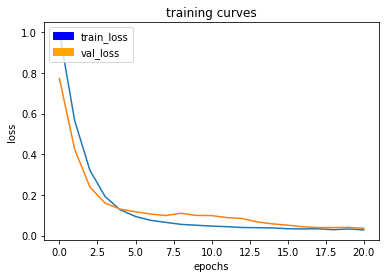

41/41 [==============================] - 76s - loss: 0.0276 - val_loss: 0.0358
Epoch 22/200
40/41 [============================>.] - ETA: 1s - loss: 0.0283

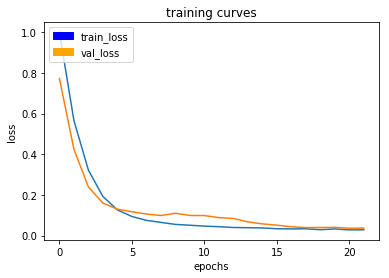

41/41 [==============================] - 75s - loss: 0.0283 - val_loss: 0.0365
Epoch 23/200
40/41 [============================>.] - ETA: 1s - loss: 0.0259

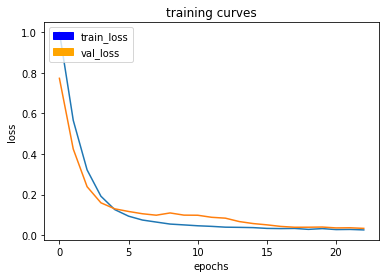

41/41 [==============================] - 75s - loss: 0.0259 - val_loss: 0.0335
Epoch 24/200
40/41 [============================>.] - ETA: 1s - loss: 0.0256

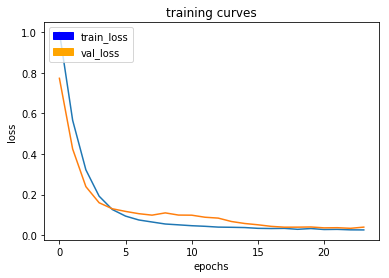

41/41 [==============================] - 76s - loss: 0.0255 - val_loss: 0.0393
Epoch 25/200
40/41 [============================>.] - ETA: 1s - loss: 0.0254

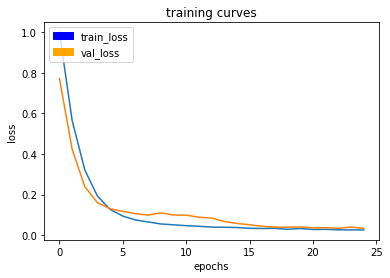

41/41 [==============================] - 75s - loss: 0.0255 - val_loss: 0.0332
Epoch 26/200
40/41 [============================>.] - ETA: 1s - loss: 0.0244

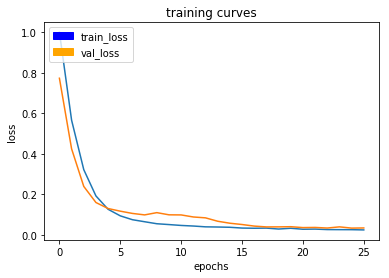

41/41 [==============================] - 76s - loss: 0.0244 - val_loss: 0.0339
Epoch 27/200
40/41 [============================>.] - ETA: 1s - loss: 0.0246

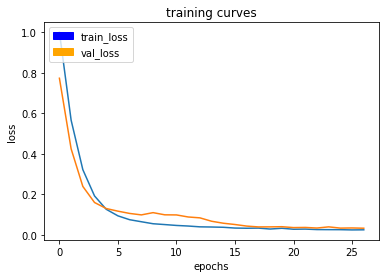

41/41 [==============================] - 75s - loss: 0.0247 - val_loss: 0.0326
Epoch 28/200
40/41 [============================>.] - ETA: 1s - loss: 0.0236

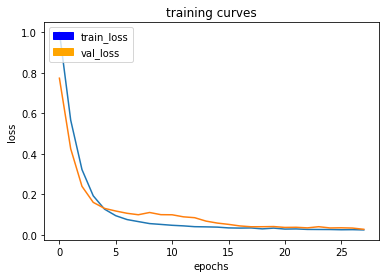

41/41 [==============================] - 76s - loss: 0.0234 - val_loss: 0.0265
Epoch 29/200
40/41 [============================>.] - ETA: 1s - loss: 0.0231

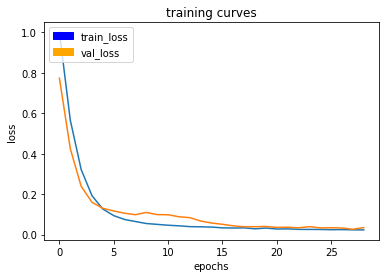

41/41 [==============================] - 76s - loss: 0.0232 - val_loss: 0.0345
Epoch 30/200
40/41 [============================>.] - ETA: 1s - loss: 0.0233

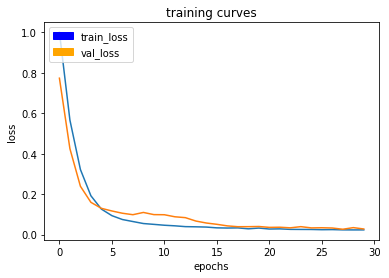

41/41 [==============================] - 75s - loss: 0.0233 - val_loss: 0.0278
Epoch 31/200
40/41 [============================>.] - ETA: 1s - loss: 0.0234

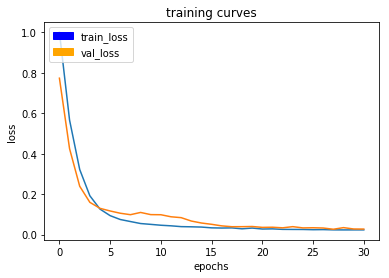

41/41 [==============================] - 75s - loss: 0.0233 - val_loss: 0.0274
Epoch 32/200
40/41 [============================>.] - ETA: 1s - loss: 0.0232

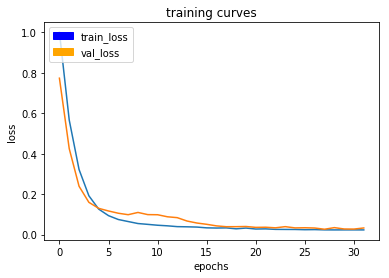

41/41 [==============================] - 75s - loss: 0.0232 - val_loss: 0.0329
Epoch 33/200
40/41 [============================>.] - ETA: 1s - loss: 0.0212

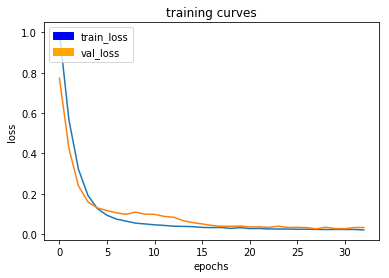

41/41 [==============================] - 76s - loss: 0.0212 - val_loss: 0.0332
Epoch 34/200
40/41 [============================>.] - ETA: 1s - loss: 0.0215

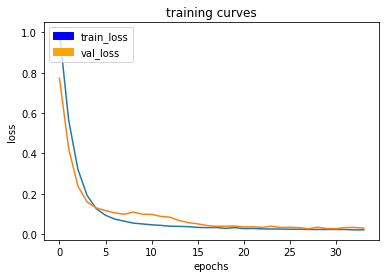

41/41 [==============================] - 76s - loss: 0.0215 - val_loss: 0.0300
Epoch 35/200
40/41 [============================>.] - ETA: 1s - loss: 0.0204

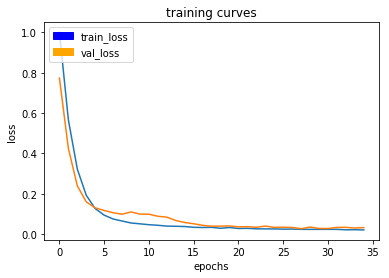

41/41 [==============================] - 76s - loss: 0.0205 - val_loss: 0.0320
Epoch 36/200
40/41 [============================>.] - ETA: 1s - loss: 0.0208

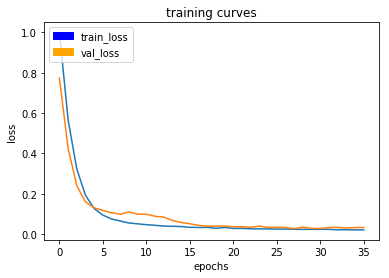

41/41 [==============================] - 75s - loss: 0.0207 - val_loss: 0.0328
Epoch 37/200
40/41 [============================>.] - ETA: 1s - loss: 0.0203

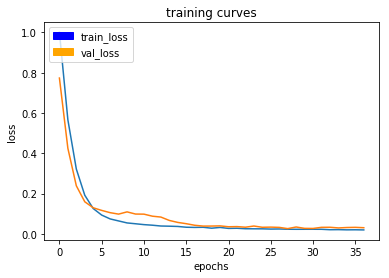

41/41 [==============================] - 75s - loss: 0.0203 - val_loss: 0.0310
Epoch 38/200
40/41 [============================>.] - ETA: 1s - loss: 0.0207

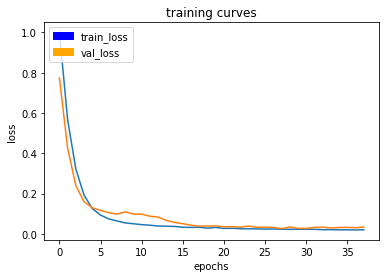

41/41 [==============================] - 76s - loss: 0.0206 - val_loss: 0.0339
Epoch 39/200
40/41 [============================>.] - ETA: 1s - loss: 0.0191

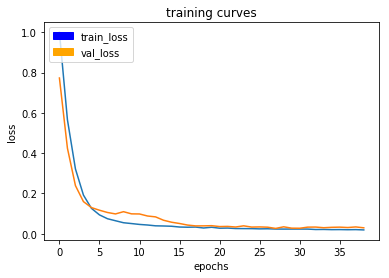

41/41 [==============================] - 75s - loss: 0.0190 - val_loss: 0.0295
Epoch 40/200
40/41 [============================>.] - ETA: 1s - loss: 0.0184

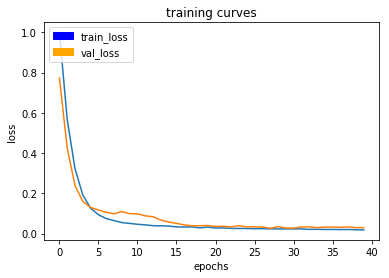

41/41 [==============================] - 75s - loss: 0.0184 - val_loss: 0.0296
Epoch 41/200
40/41 [============================>.] - ETA: 1s - loss: 0.0185

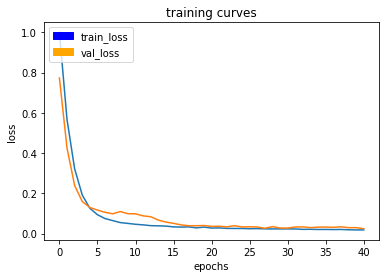

41/41 [==============================] - 76s - loss: 0.0185 - val_loss: 0.0244
Epoch 42/200
40/41 [============================>.] - ETA: 1s - loss: 0.0193

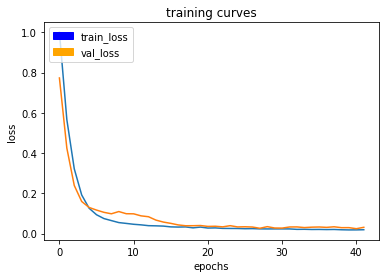

41/41 [==============================] - 75s - loss: 0.0193 - val_loss: 0.0312
Epoch 43/200
40/41 [============================>.] - ETA: 1s - loss: 0.0184

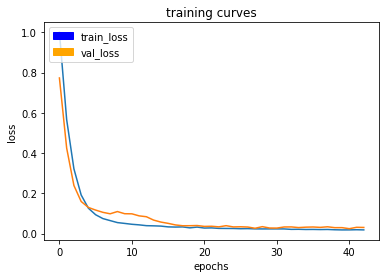

41/41 [==============================] - 75s - loss: 0.0184 - val_loss: 0.0305
Epoch 44/200
40/41 [============================>.] - ETA: 1s - loss: 0.0181

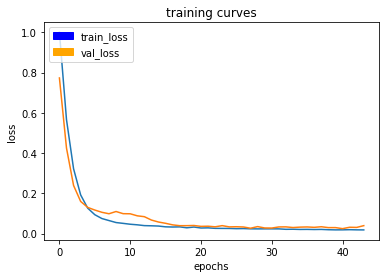

41/41 [==============================] - 76s - loss: 0.0181 - val_loss: 0.0393
Epoch 45/200
40/41 [============================>.] - ETA: 1s - loss: 0.0177

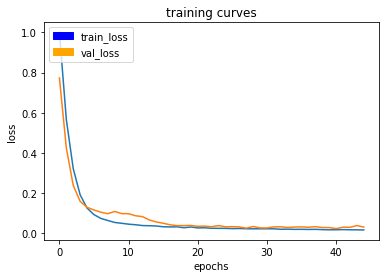

41/41 [==============================] - 77s - loss: 0.0177 - val_loss: 0.0317
Epoch 46/200
40/41 [============================>.] - ETA: 1s - loss: 0.0173

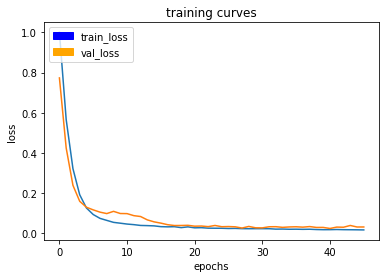

41/41 [==============================] - 76s - loss: 0.0172 - val_loss: 0.0318
Epoch 47/200
40/41 [============================>.] - ETA: 1s - loss: 0.0184

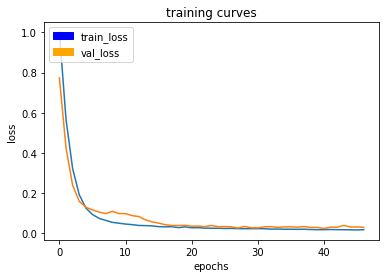

41/41 [==============================] - 75s - loss: 0.0183 - val_loss: 0.0299
Epoch 48/200
40/41 [============================>.] - ETA: 1s - loss: 0.0171

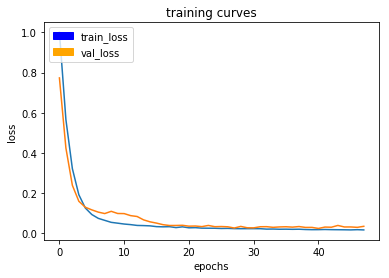

41/41 [==============================] - 76s - loss: 0.0171 - val_loss: 0.0350
Epoch 49/200
40/41 [============================>.] - ETA: 1s - loss: 0.0178

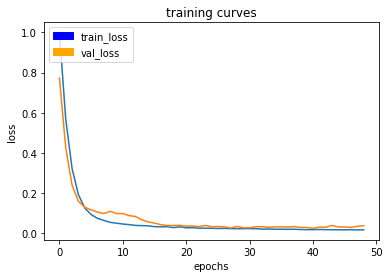

41/41 [==============================] - 76s - loss: 0.0178 - val_loss: 0.0383
Epoch 50/200
40/41 [============================>.] - ETA: 1s - loss: 0.0167

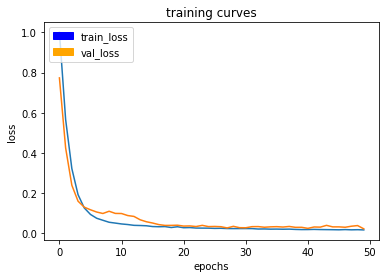

41/41 [==============================] - 75s - loss: 0.0166 - val_loss: 0.0221
Epoch 51/200
40/41 [============================>.] - ETA: 1s - loss: 0.0163

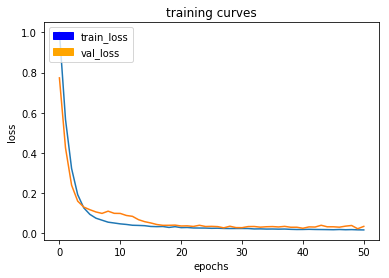

41/41 [==============================] - 75s - loss: 0.0163 - val_loss: 0.0337
Epoch 52/200
40/41 [============================>.] - ETA: 1s - loss: 0.0158

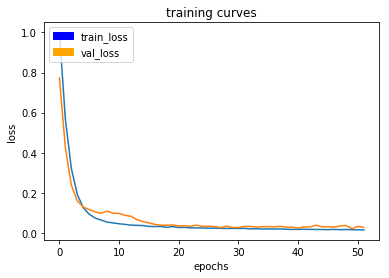

41/41 [==============================] - 75s - loss: 0.0158 - val_loss: 0.0278
Epoch 53/200
40/41 [============================>.] - ETA: 1s - loss: 0.0159

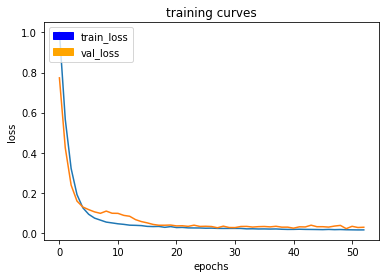

41/41 [==============================] - 76s - loss: 0.0160 - val_loss: 0.0291
Epoch 54/200
40/41 [============================>.] - ETA: 1s - loss: 0.0165

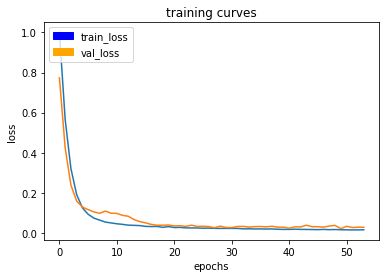

41/41 [==============================] - 76s - loss: 0.0165 - val_loss: 0.0291
Epoch 55/200
40/41 [============================>.] - ETA: 1s - loss: 0.0165

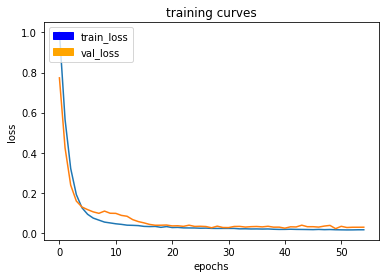

41/41 [==============================] - 75s - loss: 0.0165 - val_loss: 0.0293
Epoch 56/200
40/41 [============================>.] - ETA: 1s - loss: 0.0154

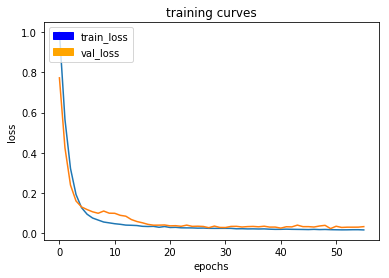

41/41 [==============================] - 76s - loss: 0.0154 - val_loss: 0.0318
Epoch 57/200
40/41 [============================>.] - ETA: 1s - loss: 0.0151

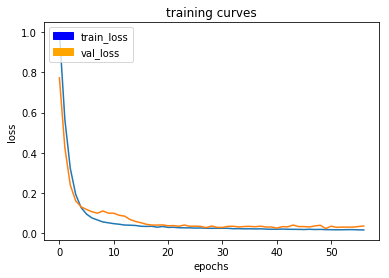

41/41 [==============================] - 76s - loss: 0.0151 - val_loss: 0.0347
Epoch 58/200
40/41 [============================>.] - ETA: 1s - loss: 0.0154

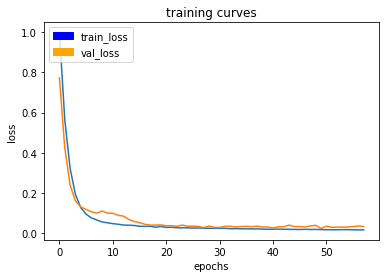

41/41 [==============================] - 75s - loss: 0.0154 - val_loss: 0.0321
Epoch 59/200
40/41 [============================>.] - ETA: 1s - loss: 0.0148

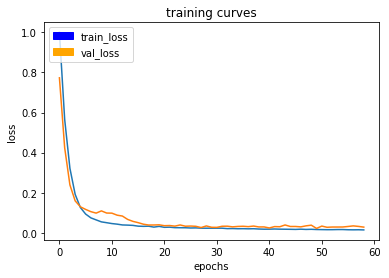

41/41 [==============================] - 76s - loss: 0.0147 - val_loss: 0.0286
Epoch 60/200
40/41 [============================>.] - ETA: 1s - loss: 0.0157

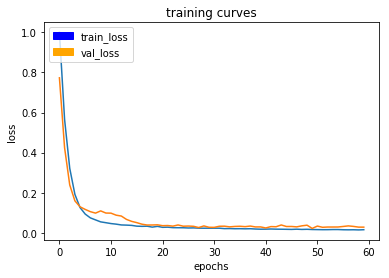

41/41 [==============================] - 76s - loss: 0.0157 - val_loss: 0.0284
Epoch 61/200
40/41 [============================>.] - ETA: 1s - loss: 0.0149

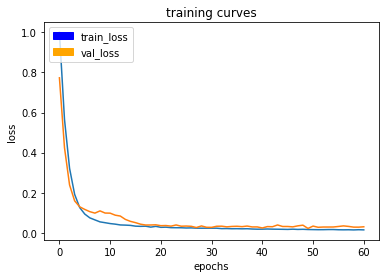

41/41 [==============================] - 75s - loss: 0.0149 - val_loss: 0.0303
Epoch 62/200
40/41 [============================>.] - ETA: 1s - loss: 0.0151

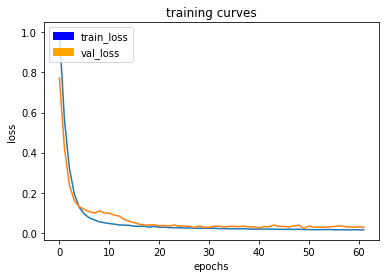

41/41 [==============================] - 75s - loss: 0.0151 - val_loss: 0.0275
Epoch 63/200
40/41 [============================>.] - ETA: 1s - loss: 0.0144

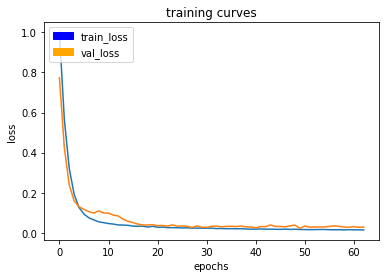

41/41 [==============================] - 76s - loss: 0.0145 - val_loss: 0.0290
Epoch 64/200
40/41 [============================>.] - ETA: 1s - loss: 0.0142

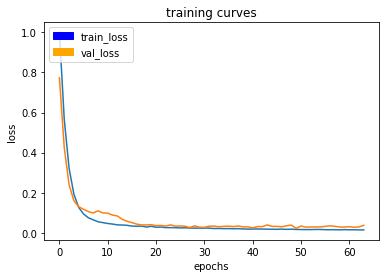

41/41 [==============================] - 76s - loss: 0.0142 - val_loss: 0.0374
Epoch 65/200
40/41 [============================>.] - ETA: 1s - loss: 0.0160

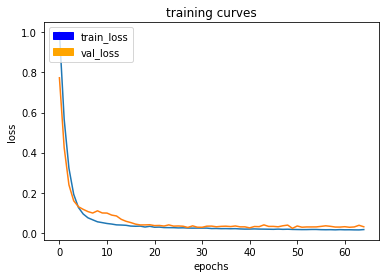

41/41 [==============================] - 76s - loss: 0.0160 - val_loss: 0.0298
Epoch 66/200
40/41 [============================>.] - ETA: 1s - loss: 0.0150

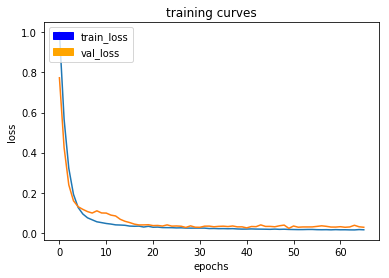

41/41 [==============================] - 75s - loss: 0.0150 - val_loss: 0.0275
Epoch 67/200
40/41 [============================>.] - ETA: 1s - loss: 0.0148

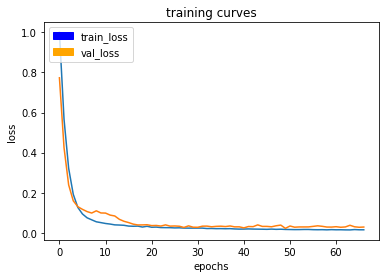

41/41 [==============================] - 75s - loss: 0.0148 - val_loss: 0.0286
Epoch 68/200
40/41 [============================>.] - ETA: 1s - loss: 0.0147

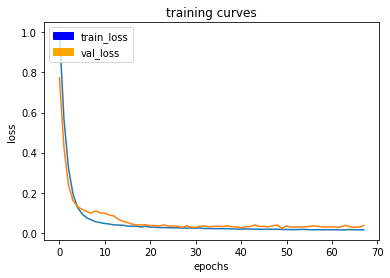

41/41 [==============================] - 76s - loss: 0.0147 - val_loss: 0.0364
Epoch 69/200
40/41 [============================>.] - ETA: 1s - loss: 0.0142

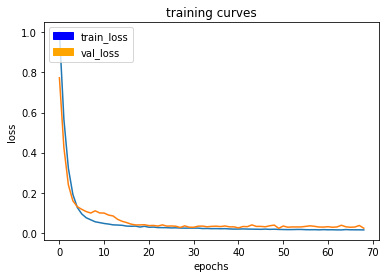

41/41 [==============================] - 75s - loss: 0.0142 - val_loss: 0.0228
Epoch 70/200
40/41 [============================>.] - ETA: 1s - loss: 0.0139

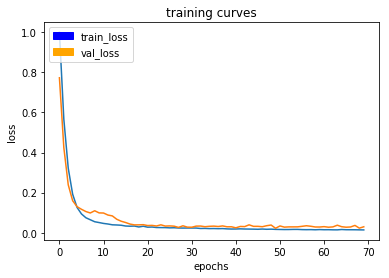

41/41 [==============================] - 75s - loss: 0.0139 - val_loss: 0.0296
Epoch 71/200
40/41 [============================>.] - ETA: 1s - loss: 0.0138

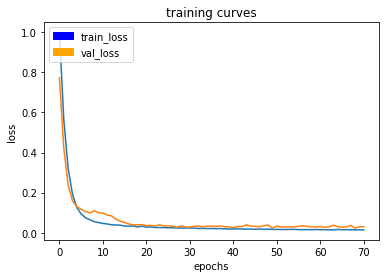

41/41 [==============================] - 76s - loss: 0.0138 - val_loss: 0.0297
Epoch 72/200
40/41 [============================>.] - ETA: 1s - loss: 0.0136

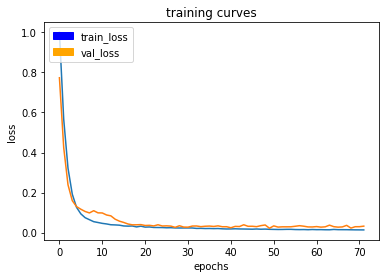

41/41 [==============================] - 75s - loss: 0.0136 - val_loss: 0.0324
Epoch 73/200
40/41 [============================>.] - ETA: 1s - loss: 0.0140

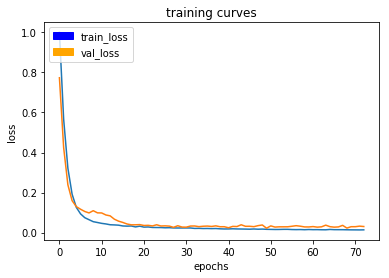

41/41 [==============================] - 75s - loss: 0.0140 - val_loss: 0.0306
Epoch 74/200
40/41 [============================>.] - ETA: 1s - loss: 0.0187

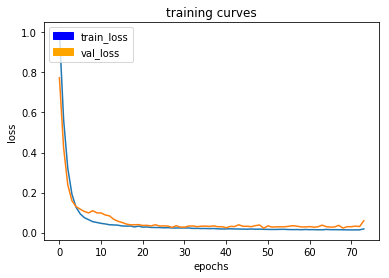

41/41 [==============================] - 75s - loss: 0.0188 - val_loss: 0.0593
Epoch 75/200
40/41 [============================>.] - ETA: 1s - loss: 0.0182

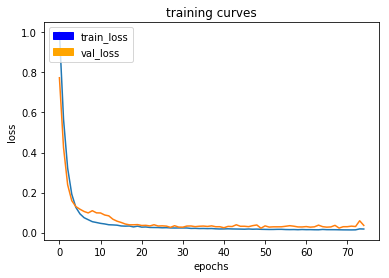

41/41 [==============================] - 76s - loss: 0.0181 - val_loss: 0.0361
Epoch 76/200
40/41 [============================>.] - ETA: 1s - loss: 0.0163

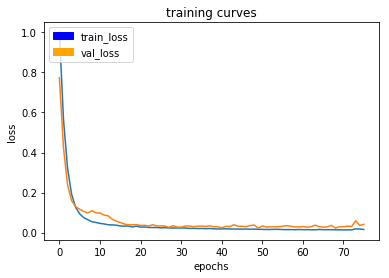

41/41 [==============================] - 76s - loss: 0.0163 - val_loss: 0.0416
Epoch 77/200
40/41 [============================>.] - ETA: 1s - loss: 0.0150

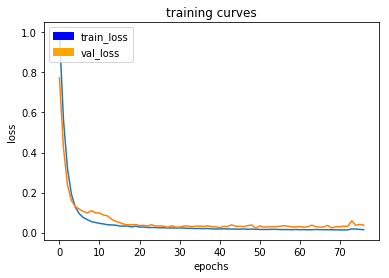

41/41 [==============================] - 76s - loss: 0.0150 - val_loss: 0.0371
Epoch 78/200
40/41 [============================>.] - ETA: 1s - loss: 0.0144

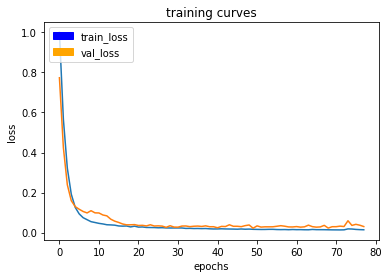

41/41 [==============================] - 75s - loss: 0.0144 - val_loss: 0.0304
Epoch 79/200
40/41 [============================>.] - ETA: 1s - loss: 0.0142

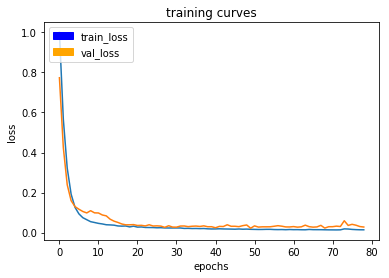

41/41 [==============================] - 76s - loss: 0.0142 - val_loss: 0.0280
Epoch 80/200
40/41 [============================>.] - ETA: 1s - loss: 0.0130

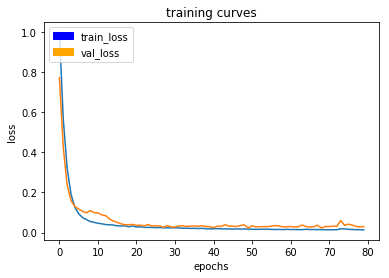

41/41 [==============================] - 76s - loss: 0.0129 - val_loss: 0.0288
Epoch 81/200
40/41 [============================>.] - ETA: 1s - loss: 0.0132

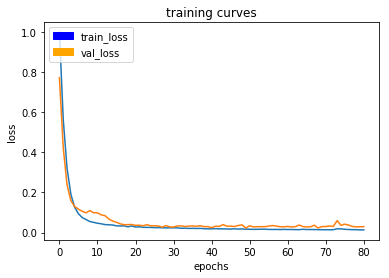

41/41 [==============================] - 75s - loss: 0.0132 - val_loss: 0.0290
Epoch 82/200
40/41 [============================>.] - ETA: 1s - loss: 0.0128

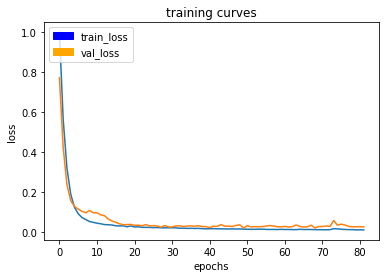

41/41 [==============================] - 75s - loss: 0.0128 - val_loss: 0.0279
Epoch 83/200
40/41 [============================>.] - ETA: 1s - loss: 0.0124

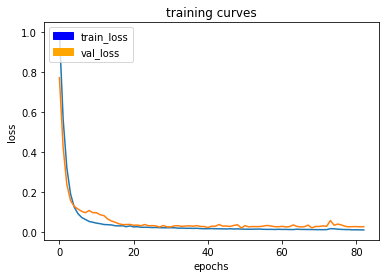

41/41 [==============================] - 76s - loss: 0.0124 - val_loss: 0.0287
Epoch 84/200
40/41 [============================>.] - ETA: 1s - loss: 0.0125

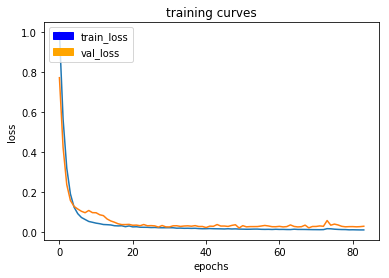

41/41 [==============================] - 76s - loss: 0.0125 - val_loss: 0.0308
Epoch 85/200
40/41 [============================>.] - ETA: 1s - loss: 0.0130

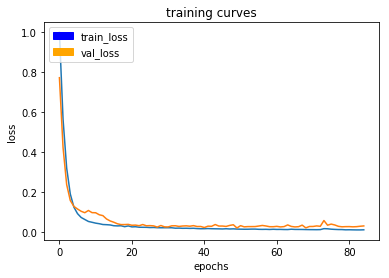

41/41 [==============================] - 76s - loss: 0.0130 - val_loss: 0.0324
Epoch 86/200
40/41 [============================>.] - ETA: 1s - loss: 0.0125

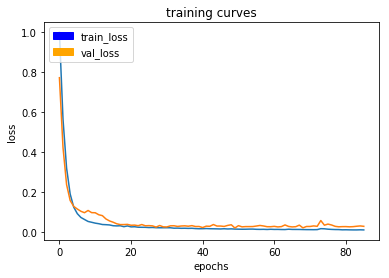

41/41 [==============================] - 77s - loss: 0.0124 - val_loss: 0.0304
Epoch 87/200
40/41 [============================>.] - ETA: 1s - loss: 0.0122

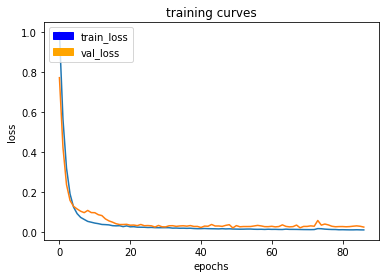

41/41 [==============================] - 75s - loss: 0.0122 - val_loss: 0.0263
Epoch 88/200
40/41 [============================>.] - ETA: 1s - loss: 0.0126

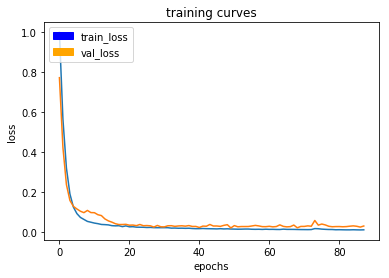

41/41 [==============================] - 77s - loss: 0.0126 - val_loss: 0.0317
Epoch 89/200
40/41 [============================>.] - ETA: 1s - loss: 0.0133

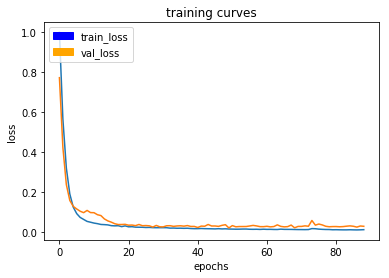

41/41 [==============================] - 75s - loss: 0.0133 - val_loss: 0.0302
Epoch 90/200
40/41 [============================>.] - ETA: 1s - loss: 0.0130

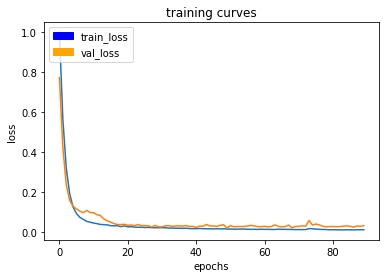

41/41 [==============================] - 76s - loss: 0.0130 - val_loss: 0.0333
Epoch 91/200
40/41 [============================>.] - ETA: 1s - loss: 0.0120

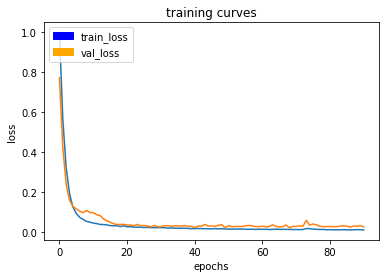

41/41 [==============================] - 76s - loss: 0.0120 - val_loss: 0.0269
Epoch 92/200
40/41 [============================>.] - ETA: 1s - loss: 0.0117

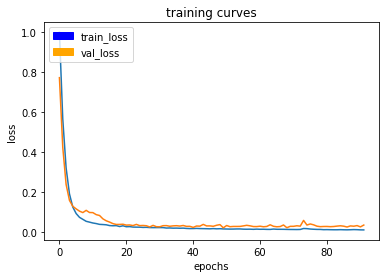

41/41 [==============================] - 76s - loss: 0.0117 - val_loss: 0.0360
Epoch 93/200
40/41 [============================>.] - ETA: 1s - loss: 0.0116

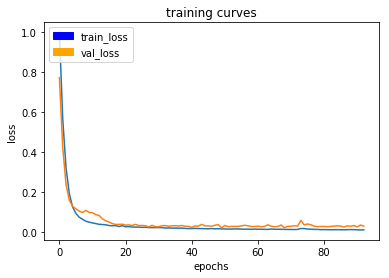

41/41 [==============================] - 76s - loss: 0.0116 - val_loss: 0.0305
Epoch 94/200
40/41 [============================>.] - ETA: 1s - loss: 0.0117

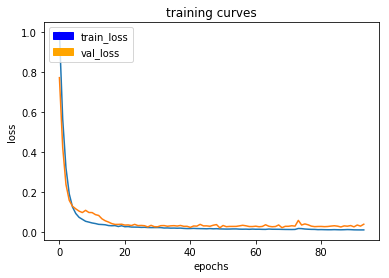

41/41 [==============================] - 76s - loss: 0.0117 - val_loss: 0.0400
Epoch 95/200
40/41 [============================>.] - ETA: 1s - loss: 0.0116

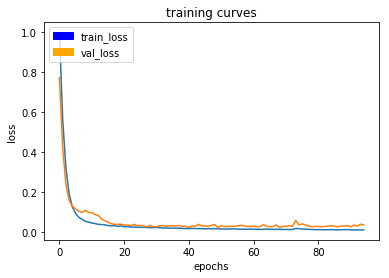

41/41 [==============================] - 75s - loss: 0.0116 - val_loss: 0.0367
Epoch 96/200
40/41 [============================>.] - ETA: 1s - loss: 0.0127

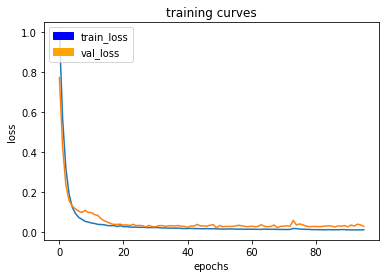

41/41 [==============================] - 76s - loss: 0.0127 - val_loss: 0.0294
Epoch 97/200
40/41 [============================>.] - ETA: 1s - loss: 0.0130

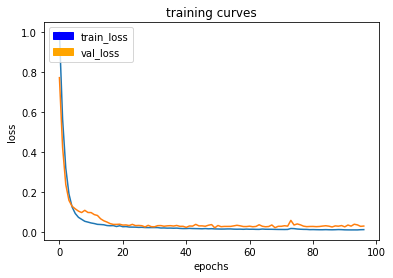

41/41 [==============================] - 76s - loss: 0.0130 - val_loss: 0.0309
Epoch 98/200
40/41 [============================>.] - ETA: 1s - loss: 0.0133

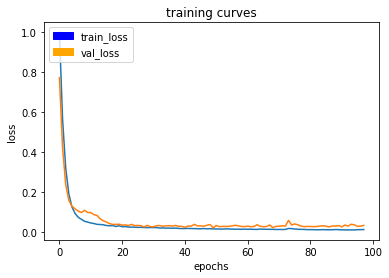

41/41 [==============================] - 76s - loss: 0.0133 - val_loss: 0.0343
Epoch 99/200
40/41 [============================>.] - ETA: 1s - loss: 0.0144

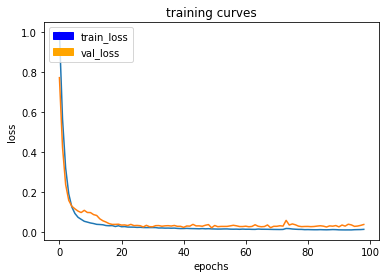

41/41 [==============================] - 76s - loss: 0.0144 - val_loss: 0.0387
Epoch 100/200
40/41 [============================>.] - ETA: 1s - loss: 0.0139

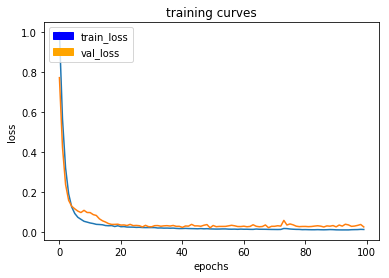

41/41 [==============================] - 75s - loss: 0.0139 - val_loss: 0.0264
Epoch 101/200
40/41 [============================>.] - ETA: 1s - loss: 0.0138

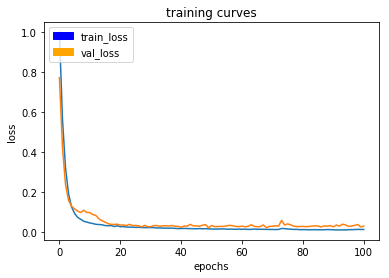

41/41 [==============================] - 76s - loss: 0.0138 - val_loss: 0.0309
Epoch 102/200
40/41 [============================>.] - ETA: 1s - loss: 0.0125

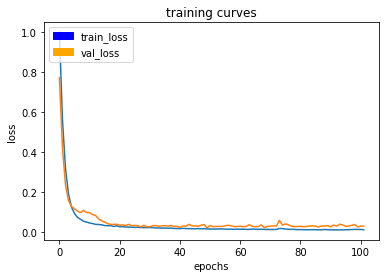

41/41 [==============================] - 75s - loss: 0.0125 - val_loss: 0.0301
Epoch 103/200
32/41 [======================>.......] - ETA: 15s - loss: 0.0120

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [ ]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [3]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights'
restored_model = model_tools.load_network(weight_file_name)restored_model

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [5]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(restored_model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(restored_model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(restored_model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

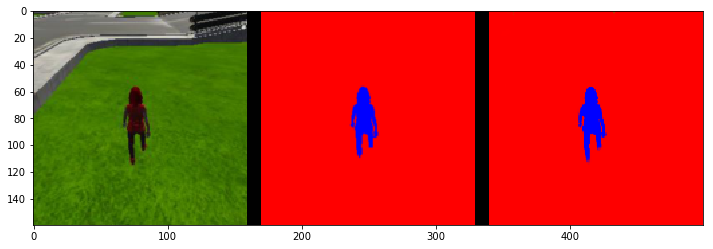

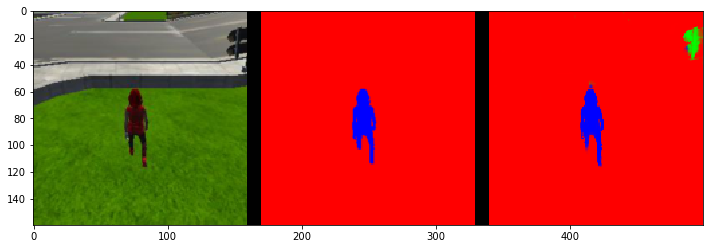

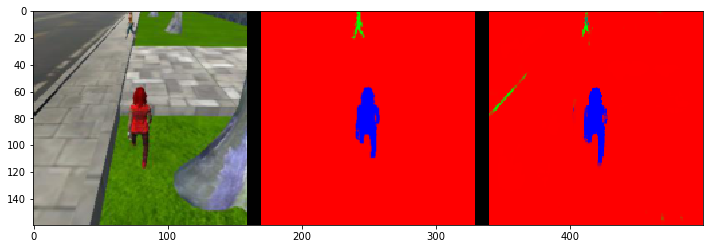

In [6]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

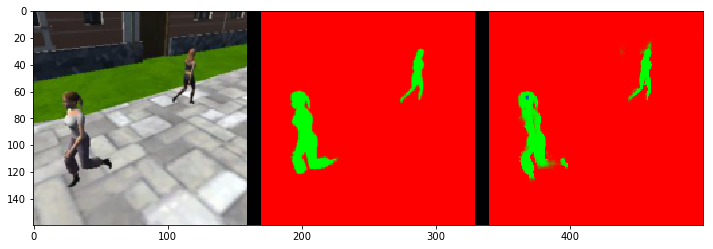

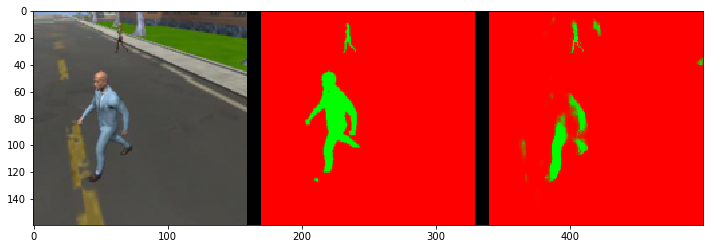

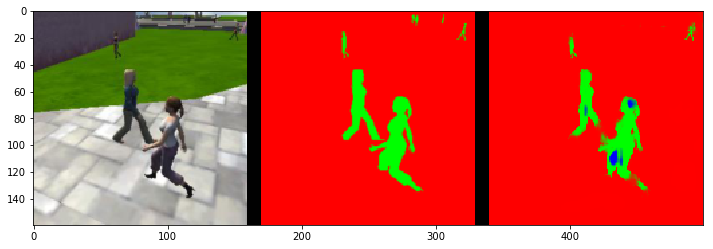

In [7]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

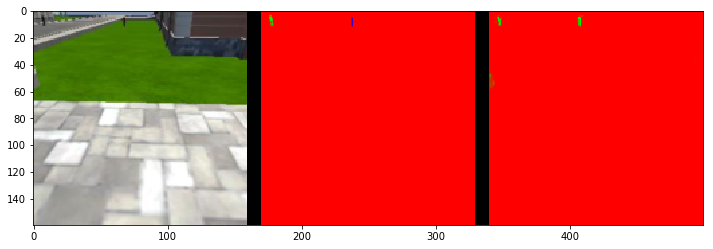

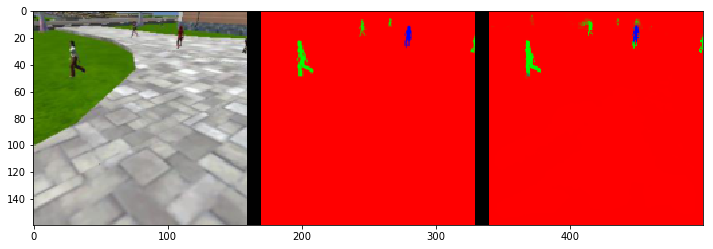

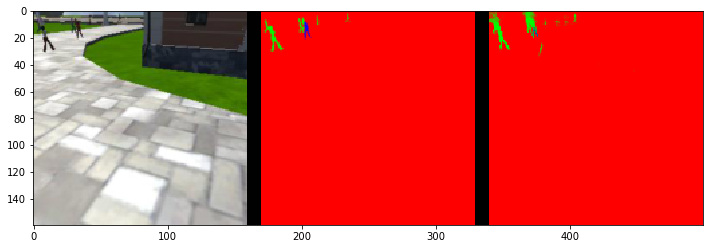

In [8]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [9]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9951799634880235
average intersection over union for other people is 0.3429706051413025
average intersection over union for the hero is 0.8961560961764891
number true positives: 539, number false positives: 0, number false negatives: 0


In [10]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9853863483394628
average intersection over union for other people is 0.6656603030849713
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 161, number false negatives: 0


In [11]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9961024810417898
average intersection over union for other people is 0.4325341990631022
average intersection over union for the hero is 0.2175554531946484
number true positives: 137, number false positives: 6, number false negatives: 164


In [12]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.6713008937437934


In [13]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.556855774686


In [14]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.373817779233


In [15]:
model.summary()

NameError: name 'model' is not defined